#### From Neurons to Neutrons: A Case Study in Interpretability

In this notebook, we show how you can extract the the penultimate layer features, and the embeddings of the model, as shown in the paper.

---

#### Features

In [22]:
# Make sure to install the requirements with pip install -r requirements.txt

import glob
import seaborn as sns
import numpy as np
import torch
from src.utils import  PlottingContext, IO
from src.data import prepare_nuclear_data
from src.model import get_model_and_optim
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib as mpl

sns.set_style('darkgrid')
sns.set_context('paper')

First, we are going to find and load the model:

In [16]:
# extract the subfolders in your models directory
locations = glob.glob('models/*')

keys = [l.split('/')[-1].split('-')[0] for l in locations]
locations = {key:l for key, l in zip(keys, locations)}

In [17]:
# take the model trained on binding energies and load it
model_name = 'binding'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

mask = data.train_mask & ~torch.isnan(data.y[:, 0])
X_train = data.X[mask]
y_train = data.y[mask]

Loading model from models/binding-single-task/ckpts/model.pt


Now, we are going to get the penultimate layer activations:

In [18]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts
    

X = data.X
y = data.y
mask = lambda x: x[(X[:, 2] == 0) & ~torch.isnan(y.view(-1))]
X, y = mask(X), mask(y)

acts = get_penultimate_acts(model, X)

Now, we are going to obtain the PC features of the activations:

In [19]:
pca = PCA(n_components=20)
pca.fit(acts.detach().cpu().numpy())
acts_pca = pca.transform(acts.detach().cpu().numpy())

We can now plot them:

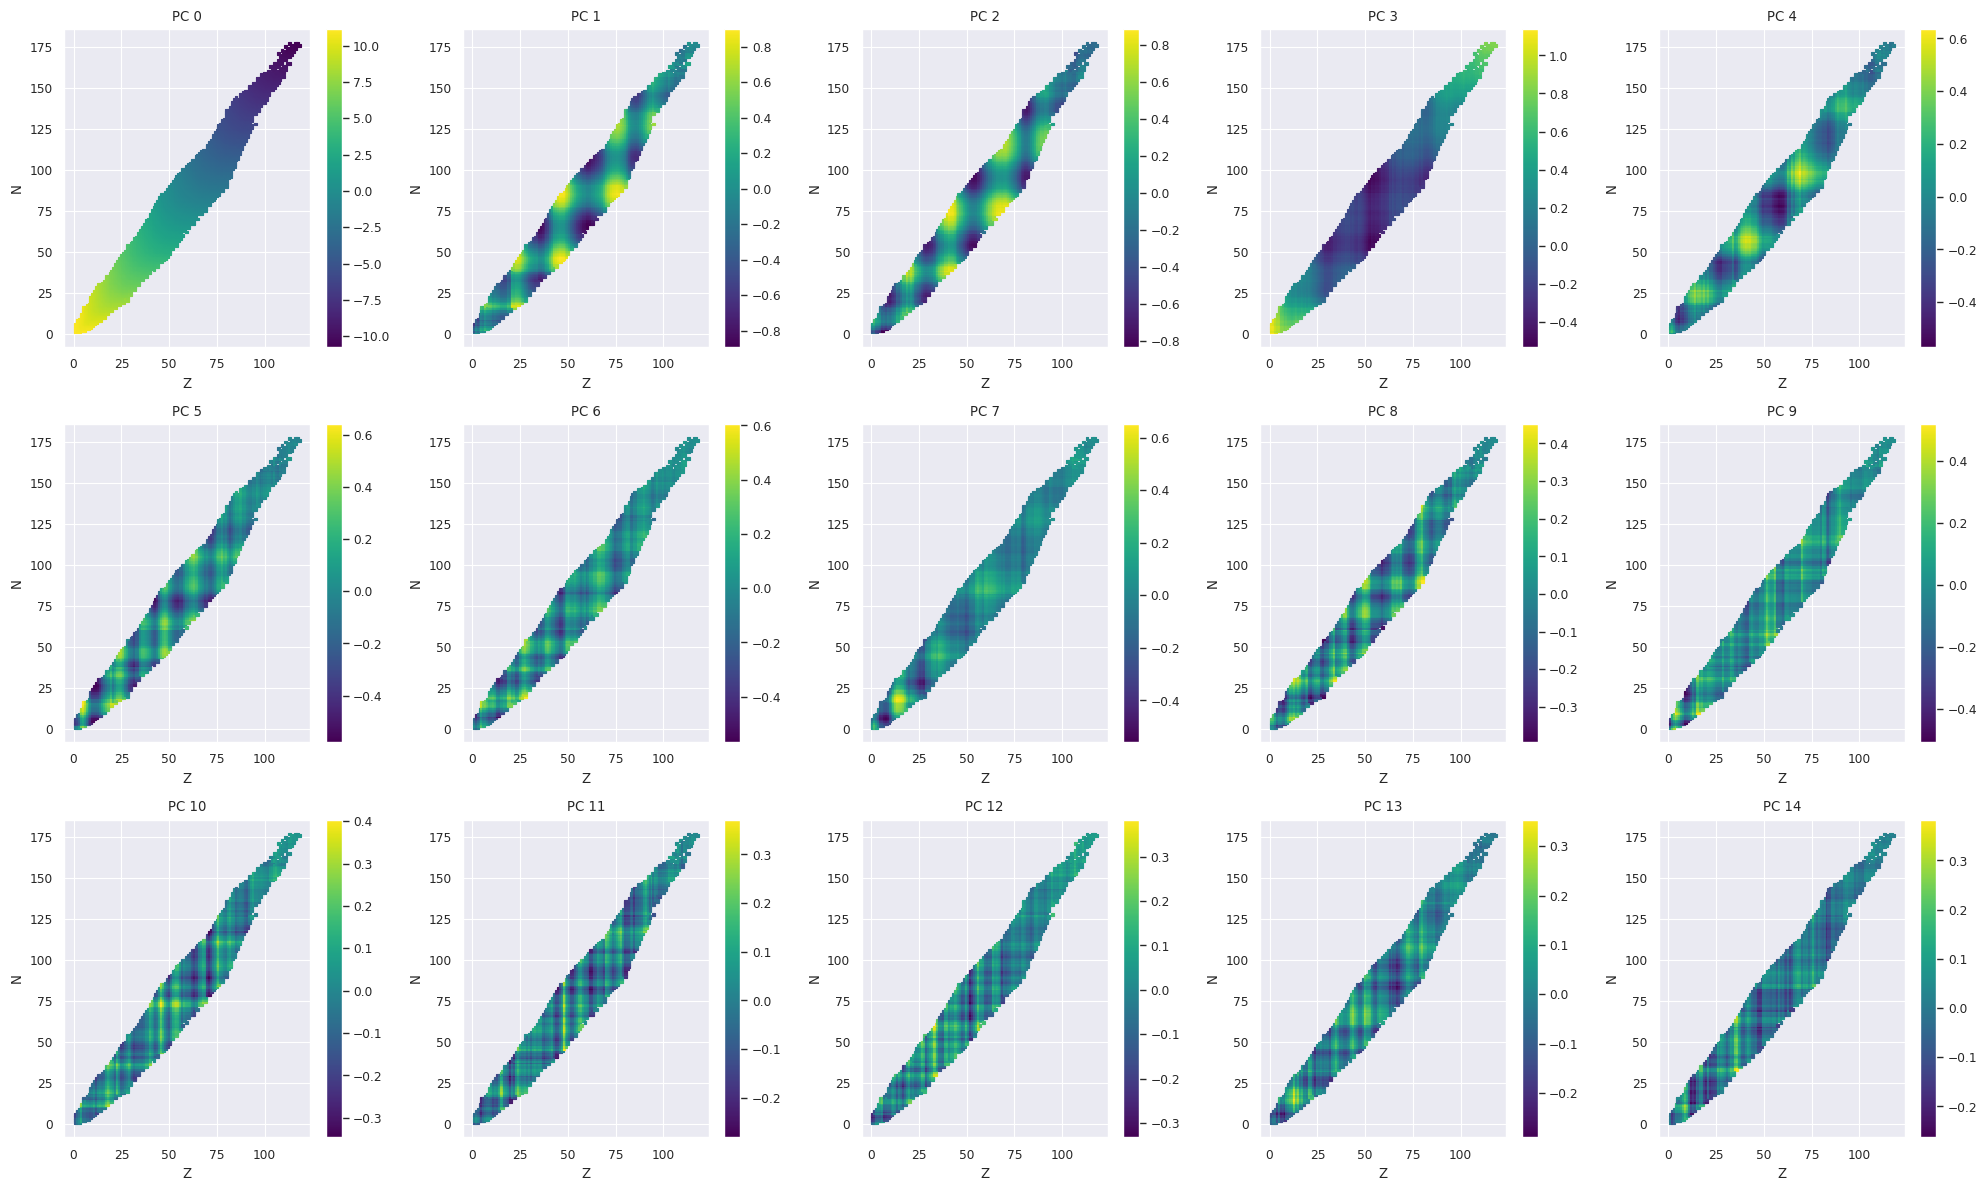

In [20]:
Z, N = X[:, :2].detach().cpu().numpy().T

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for i in range(len(axes.flatten())):
    ax = axes[i//5, i%5]
    plt.sca(ax)
    plt.scatter(Z, N, c=acts_pca[:, i], cmap="viridis", s=4, marker="s")
    plt.xlabel("Z")
    plt.ylabel("N")
    plt.title(f"PC {i}")
    plt.colorbar()
fig.tight_layout()
plt.show()

---

#### Embeddings

We will get the embeddings of $Z$ and $N$ and project them.

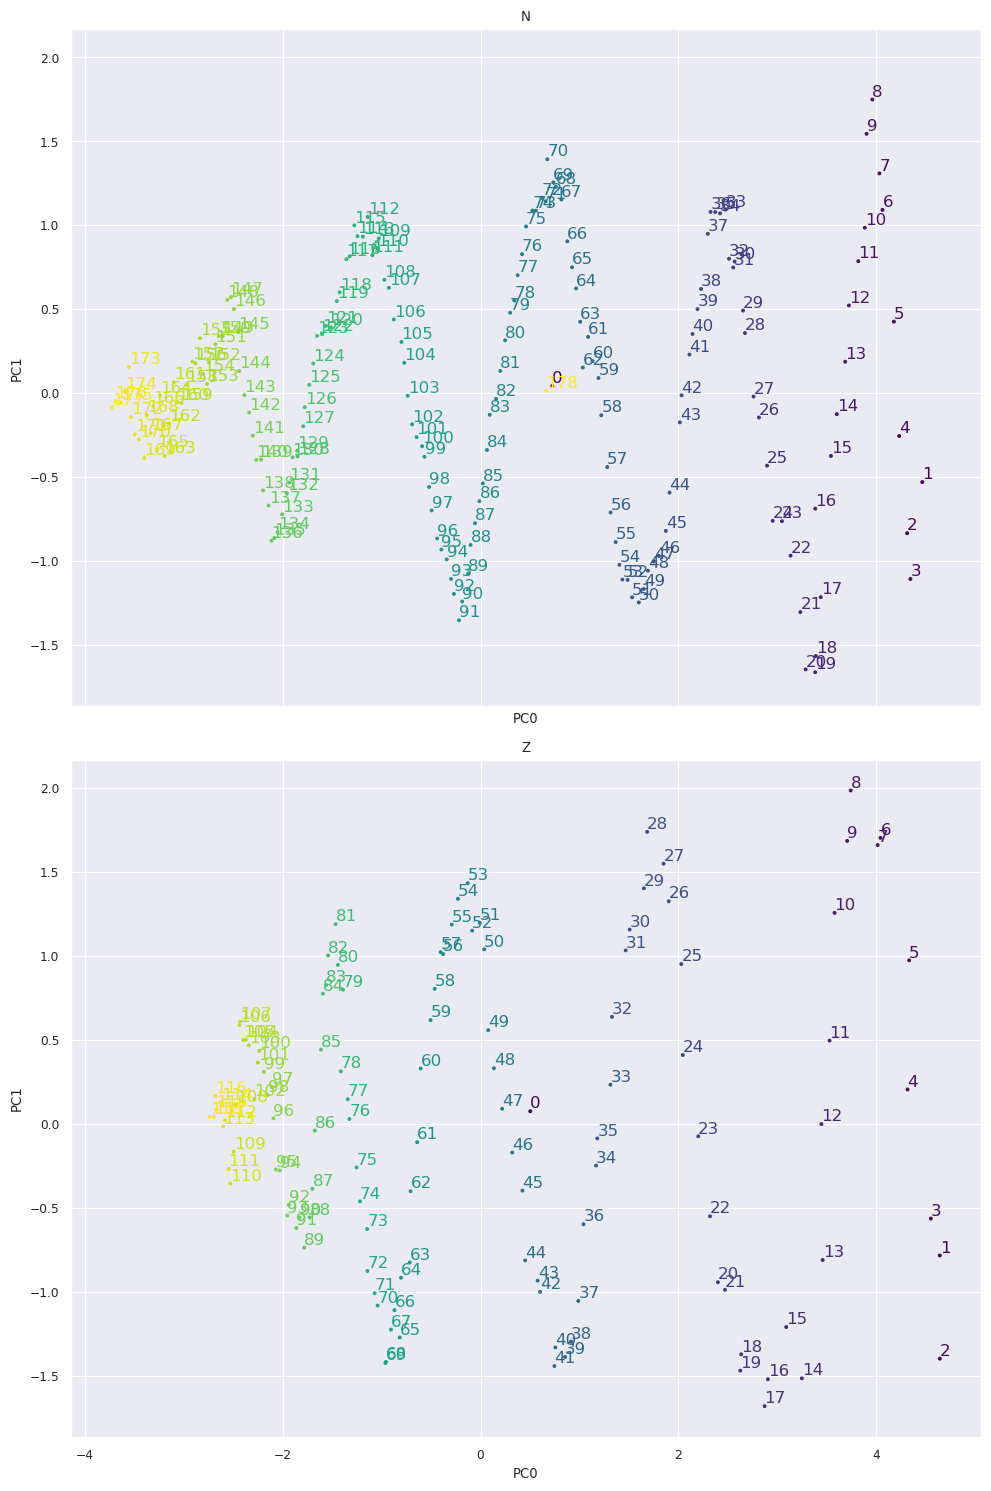

In [28]:
cmap = "viridis"
def get_embs(emb):
    emb = PCA(n_components=5).fit_transform(emb)
    Z = np.arange(len(emb))
    norm = mpl.colors.Normalize(vmin=min(Z), vmax=max(Z))
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    Z = sm.to_rgba(Z)
    return emb, Z

Z_emb, Z = get_embs(model.emb[0].detach().cpu().numpy())
N_emb, N = get_embs(model.emb[1].detach().cpu().numpy())

# plot the embeddings, Z and N are the columns
fig, ax = plt.subplots(2, 1, figsize=(10, 15), sharex=True, sharey=True)
# PC1 vs PC0
def plot_ax0(Z_emb, Z, ax, x_pc=0, y_pc=1, title="Z"):
    plt.sca(ax)
    plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, s=4)
    PlottingContext.scatter_text(np.arange(len(Z)), Z_emb[:, x_pc], Z_emb[:, y_pc], colors=Z, ax=plt.gca())
    plt.xlabel("PC0"); plt.ylabel("PC1"); plt.title(title)

plot_ax0(N_emb, N, ax[0], title="N")

plot_ax0(Z_emb, Z, ax[1], title="Z")
# PC1 vs PC0
fig.tight_layout()


We can project the $Z$ embeddings onto the first two PCs, and relate it to the binding energies predictions.

Text(0.5, 1.0, 'Z PCs, fixed N=100')

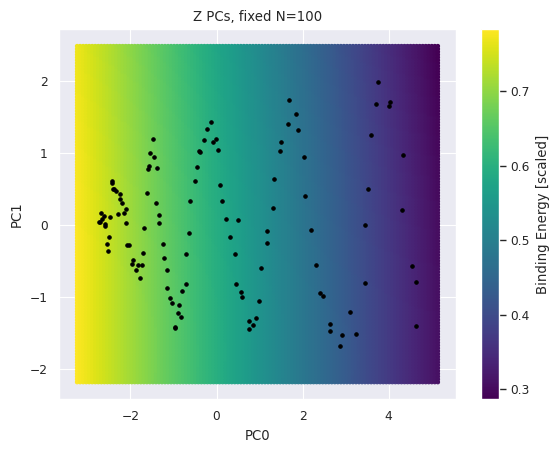

In [32]:
# project embeddings to the first two PCs
grid_size = 120
emb = model.emb[0].detach().cpu().numpy()
pca = PCA(n_components=2)
emb_ = pca.fit_transform(emb)
emb = torch.from_numpy(pca.inverse_transform(emb_))

# define grid boundaries and create a mesh grid for visualization
idx_0, idx_1 =  0, 1
x_min, x_max = emb_[:, 0].min() - .5, emb_[:, 0].max() + .5
y_min, y_max = emb_[:, 1].min() - .5, emb_[:, 1].max() + .5
grid = np.meshgrid(np.linspace(x_min, x_max, grid_size), np.linspace(y_min, y_max, grid_size))
grid = np.stack(grid, axis=-1).reshape(-1, 2)

# generate the input of the form [[0, N, 0], [1, N, 0], [2, N, 0], ...]
emb_grid = torch.from_numpy(pca.inverse_transform(grid)).float()
x = torch.zeros(len(emb_grid), 3, dtype=torch.long)
x[:, 1] = (N:=100) # fixed N
x[:, 0] = torch.arange(len(emb_grid))

# embed input and get the output
x = model.embed_input(x, [emb_grid, model.emb[1], model.emb[2]])
x = model.readout(model.nonlinear(x))

# scatter plot of the output
fig, ax = plt.subplots()
# create color bar object with vmin and vmax
sm = mpl.cm.ScalarMappable(cmap=cmap)
c = sm.to_rgba(x[:, 0].detach().cpu().numpy())
sc = ax.scatter(grid[:, 0], grid[:, 1], c=c, s=6)
plt.colorbar(sm, label="Binding Energy [scaled]", ax=ax)
plt.scatter(emb_[:, 0], emb_[:, 1], c='k', s=6)
plt.xlabel("PC0"); plt.ylabel("PC1")
plt.title(f"Z PCs, fixed N={N}")